# Описание задачи
## В задачи пректа входит:
- Нахождение данных для обученяи модели: парсинг и/или иные источники;
- Предобработка полученных данных
- Создание новых признаков с использованием полученных данных;
- Отбор признаков;
- Отбор моделей;
- Обучение и тестирование отобранной модели на отобранных признаках;
- Подбор макропараметров модели на отобранных признаках;
- Получение предсказанных моделью значений, подготовка и отправка submission

# Импорт библиотек, установка параметров, определение функций
## Импорт бибилиотек

In [1]:
import pandas as pd
import numpy as np
import json 
import os
import requests

from pprint import pprint
from bs4 import BeautifulSoup 

## Установка параметров

In [2]:
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

Populating the interactive namespace from numpy and matplotlib


## Определение функций

In [3]:
def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc



def preproc():
    pass

# Изучение  данных для предсказания

Что бы понимать какие признаки нам нужны для обучения модели нам необходимо понять какие признаки описывают наблюдения, для которых мы должны предсказать целевую переменную.  

Поэтому для начала исследуем данные эти наблюдения описывающие.

In [1]:
df_test = pd.read_csv('./Project_5_data/test.csv')
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

df_describe(df_test)df
df_describe(df)


SyntaxError: invalid syntax (<ipython-input-1-bbf32256a67a>, line 4)

In [5]:
# df_test.head()

In [6]:
df_test.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id'],
      dtype='object')

### bodyType

In [7]:
# df_test.bodyType.unique()
# df_test.bodyType.value_counts()

pd.get_dummies(df_test.bodyType)[:5]

,внедорожник 5 дв.,кабриолет,компактвэн,купе,лифтбек,родстер,седан,седан 2 дв.,универсал 5 дв.,хэтчбек 3 дв.,хэтчбек 5 дв.
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


### brand

In [8]:
df_test.brand.unique()

array(['BMW'], dtype=object)

### color

In [9]:
df_test.color.unique()

array(['чёрный', 'белый', 'синий', 'коричневый', 'красный', 'серый',
       'бежевый', 'серебристый', 'золотистый', 'оранжевый', 'голубой',
       'пурпурный', 'жёлтый', 'зелёный', 'фиолетовый'], dtype=object)

In [10]:
pd.get_dummies(df_test.color)[:5]

,бежевый,белый,голубой,жёлтый,зелёный,золотистый,коричневый,красный,оранжевый,пурпурный,серебристый,серый,синий,фиолетовый,чёрный
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### fuelType

In [11]:
df_test.fuelType.unique()

array(['дизель', 'бензин', 'гибрид', 'электро'], dtype=object)

In [12]:
pd.get_dummies(df_test.fuelType)[:5]

,бензин,гибрид,дизель,электро
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


### modelDate

In [13]:
df_test.modelDate.unique()

array([2016., 2018., 2009., 2014., 2013., 2010., 2006., 2011., 2007.,
       2005., 2008., 2000., 2012., 2015., 2017., 2002., 2001., 1999.,
       2003., 1998., 2019., 1990., 1995., 2004., 1987., 1981., 1994.,
       1986., 1982., 1975., 1977.])

In [14]:
df_test.modelDate.astype(int)[:5]

0    2016
1    2018
2    2009
3    2014
4    2014
Name: modelDate, dtype: int32

### name

In [5]:
df_test.name.loc[0]

'520d 2.0d AT (190 л.с.)'

In [15]:
df_test.name.apply(lambda x: x[:x.find(' ')])[:5]

0    520d
1    318d
2    550i
3     30d
4    M50d
Name: name, dtype: object

In [16]:
df_test.name.apply(lambda x: x[:x.find(' ')]).unique()

array(['520d', '318d', '550i', '30d', 'M50d', '28i', '20d', '520i',
       '328i', '116i', '730d', '320i', '335i', '25i', '316i', '3.0d',
       '540i', '730Ld', '35d', '20i', '530d', '528i', '35i', 'xDrive20d',
       '48i', '135i', '2.2', '335xi', '745i', '320d', '530xi', '530i',
       '3.0i', '325i', '30i', '118i', '40i', 'M760Li', '3.0si', '4.4',
       '40d', '4.8i', '535d', '420i', '525i', '750i', '120i', '330i',
       '120d', '318i', '725Ld', '760Li', '840d', '420d', 'M850i', '523i',
       '18d', '650i', '18i', '525d', '750Li', '4.4i', '630d', '645i',
       '3.0', '25d', '535i', '640i', '330xd', 'xDrive20i', '525xi', '50i',
       '740Li', 'M550d', '630i', '4.0', '520Li', '735i', '730Li', '740d',
       '325xi', '518', 'M235i', '220i', '740i', 'Competition', 'M50i',
       '428i', '1.5', '750Ld', 'M40d', '730i', '1.5hyb', '528Li', '640d',
       '3.0sd', 'Electro', '530Li', '740Ld', 'CS', '525xd', 'M40i',
       '330xi', 'M340i', 'M550i', '750d', '35is', '760i', '125i', '130

In [17]:
df_test.name.sort_values().unique()[:10]

array(['1.5 AT (136 л.с.)', '1.5hyb AT (231 л.с.) 4WD',
       '116i 1.6 AT (115 л.с.)', '116i 1.6 AT (136 л.с.)',
       '116i 1.6 MT (115 л.с.)', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       '118i 1.5 AT (136 л.с.)', '118i 1.6 AT (136 л.с.)'], dtype=object)

In [18]:
# pwr = lambda x: x[x.find('(')+1:x.find(')')]
# ltr = lambda x: x[:x.find(' ')]
# df_test.name.apply(ltr)
df_test.loc[5][['name','fuelType','engineDisplacement','vehicleTransmission','enginePower','Привод']]

name                   30d 3.0d AT (249 л.с.) 4WD
fuelType                                   дизель
engineDisplacement                        3.0 LTR
vehicleTransmission                автоматическая
enginePower                               249 N12
Привод                                     полный
Name: 5, dtype: object

### numberOfDoors

In [19]:
print(df_test.numberOfDoors.unique())
df_test.numberOfDoors.astype(int)[:5]

[4. 5. 3. 2.]


0    4
1    4
2    4
3    5
4    5
Name: numberOfDoors, dtype: int32

### productionDate

In [20]:
df_test.productionDate.unique()

array([2017., 2019., 2012., 2015., 2013., 2008., 2011., 2016., 2007.,
       2014., 2000., 2009., 2018., 2005., 2003., 2006., 2010., 2002.,
       2004., 2001., 1997., 1998., 1999., 1995., 1996., 1993., 1987.,
       1984., 1989., 1991., 1988., 1994., 1992., 1981., 1990., 1986.,
       1982.])

In [21]:
df_test.productionDate.astype(int).unique()

array([2017, 2019, 2012, 2015, 2013, 2008, 2011, 2016, 2007, 2014, 2000,
       2009, 2018, 2005, 2003, 2006, 2010, 2002, 2004, 2001, 1997, 1998,
       1999, 1995, 1996, 1993, 1987, 1984, 1989, 1991, 1988, 1994, 1992,
       1981, 1990, 1986, 1982], dtype=int64)

### vehicleConfiguration

In [39]:
# df_test.vehicleConfiguration.sort_values().unique()
df_test.vehicleConfiguration.unique()[:10]

array(['SEDAN AUTOMATIC 2.0', 'SEDAN AUTOMATIC 4.4',
       'ALLROAD_5_DOORS AUTOMATIC 3.0', 'ALLROAD_5_DOORS AUTOMATIC 2.0',
       'HATCHBACK_3_DOORS AUTOMATIC 1.6', 'SEDAN AUTOMATIC 3.0',
       'ALLROAD_5_DOORS AUTOMATIC 2.5', 'SEDAN AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.6',
       'ALLROAD_5_DOORS AUTOMATIC 4.8'], dtype=object)

In [25]:
df_test.vehicleConfiguration[:5]

0              SEDAN AUTOMATIC 2.0
1              SEDAN AUTOMATIC 2.0
2              SEDAN AUTOMATIC 4.4
3    ALLROAD_5_DOORS AUTOMATIC 3.0
4    ALLROAD_5_DOORS AUTOMATIC 3.0
Name: vehicleConfiguration, dtype: object

In [32]:
df_test.vehicleConfiguration.str.split().head()

0              [SEDAN, AUTOMATIC, 2.0]
1              [SEDAN, AUTOMATIC, 2.0]
2              [SEDAN, AUTOMATIC, 4.4]
3    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
4    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
Name: vehicleConfiguration, dtype: object

In [29]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[0]).unique()

array(['SEDAN', 'ALLROAD_5_DOORS', 'HATCHBACK_3_DOORS',
       'HATCHBACK_5_DOORS', 'COUPE', 'ROADSTER', 'LIFTBACK',
       'WAGON_5_DOORS', 'CABRIO', 'SEDAN_2_DOORS', 'COMPACTVAN'],
      dtype=object)

In [30]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[1]).unique()

array(['AUTOMATIC', 'MECHANICAL', 'ROBOT'], dtype=object)

In [40]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN).unique()

array(['2.0', '4.4', '3.0', '1.6', '2.5', '4.8', '2.2', '6.6', '1.5',
       '6.0', '1.8', '3.5', '2.8', '4.0', '3.6', '5.4', '2.9', nan, '1.9',
       '5.0', '4.6', '3.4'], dtype=object)

### vehicleTransmission

In [23]:
df_test.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'роботизированная'], dtype=object)

### engineDisplacement

In [24]:
df_test.engineDisplacement.sort_values().unique(), #df.engineDisplacement.sort_values().unique()

(array(['1.5 LTR', '1.6 LTR', '1.8 LTR', '1.9 LTR', '2.0 LTR', '2.2 LTR',
        '2.5 LTR', '2.8 LTR', '2.9 LTR', '3.0 LTR', '3.4 LTR', '3.5 LTR',
        '3.6 LTR', '4.0 LTR', '4.4 LTR', '4.6 LTR', '4.8 LTR', '5.0 LTR',
        '5.4 LTR', '6.0 LTR', '6.6 LTR', 'undefined LTR'], dtype=object),)

In [45]:
df_test.engineDisplacement.apply(lambda x: x.split()[0])[:10]

0    2.0
1    2.0
2    4.4
3    3.0
4    3.0
5    3.0
6    2.0
7    2.0
8    3.0
9    2.0
Name: engineDisplacement, dtype: object

In [52]:
mask = (df_test.engineDisplacement.apply(lambda x: x.split()[0])!=
 df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN))
df_test[mask][['engineDisplacement','vehicleConfiguration']]

,engineDisplacement,vehicleConfiguration
823,undefined LTR,HATCHBACK_5_DOORS AUTOMATIC


### enginePower

In [25]:
df_test.enginePower.sort_values().unique()
df_test.enginePower.str[:-4].astype(int).sort_values().unique()

array([ 90, 100, 102, 105, 113, 115, 118, 122, 125, 129, 136, 140, 143,
       150, 156, 163, 170, 177, 184, 188, 190, 192, 193, 197, 204, 211,
       218, 230, 231, 235, 243, 245, 249, 252, 258, 264, 265, 269, 272,
       286, 300, 306, 313, 320, 326, 329, 333, 340, 347, 355, 360, 367,
       370, 374, 381, 400, 407, 410, 420, 431, 445, 449, 450, 460, 462,
       507, 530, 544, 555, 560, 575, 600, 609, 610, 625], dtype=int64)

In [26]:
# df.enginePower.sort_values().unique()

### mileage

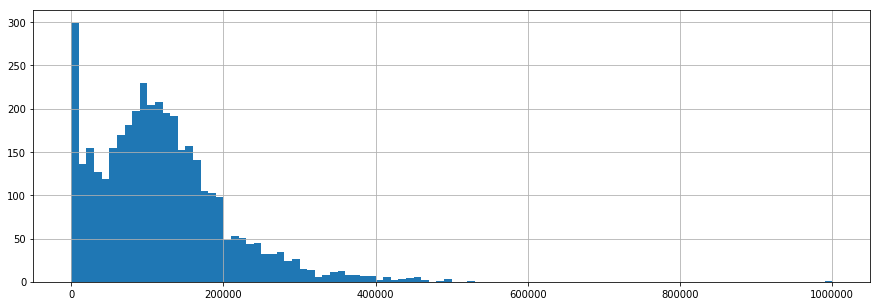

In [60]:
df_test.mileage.nunique()
df_test.mileage.hist(figsize=(15,5),bins=100)

### Комплектация

In [61]:
df_test.Комплектация.nunique()

3295

### Привод

In [63]:
df_test.Привод.unique() #, df.Привод.unique()

array(['задний', 'полный', 'передний'], dtype=object)

### Руль

In [64]:
df_test.Руль.unique() #, df_test.Руль.unique()

array(['Левый'], dtype=object)

### Состояние

In [65]:
df_test.Состояние.unique() #, df.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

### Владельцы

In [66]:
df_test.Владельцы.unique() #, df.Владельцы.unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более'], dtype=object)

### ПТС

In [67]:
df_test.ПТС.unique() #, df.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

### Таможня

In [68]:
df_test.Таможня.unique()#,df_test.Таможня.unique()

array(['Растаможен'], dtype=object)

### Владение

In [70]:
df_test.Владение.sort_values().unique()[:10]

array(['1 год', '1 год и 1 месяц', '1 год и 10 месяцев',
       '1 год и 11 месяцев', '1 год и 2 месяца', '1 год и 3 месяца',
       '1 год и 4 месяца', '1 год и 5 месяцев', '1 год и 6 месяцев',
       '1 год и 7 месяцев'], dtype=object)

In [71]:
# df.Владение.sort_values().unique()[:10]

In [72]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0

df_test.Владение.apply(lambda x: year(x)*12 + month(x) if x==x else x)[:10]

0     NaN
1     NaN
2    86.0
3     NaN
4     NaN
5     NaN
6    35.0
7     NaN
8    84.0
9     NaN
Name: Владение, dtype: float64

### id

In [34]:
print(df_test.id.unique())
try: 
    print(df.id.unique())
except:  
    pass

[   0    1    2 ... 3834 3835 3836]


## ===============================================================

## df_test.Комплектация


In [35]:
df_test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [36]:
new_configuration = df_test.Комплектация.apply(lambda x: json.loads(x[2:-2]) if x != '[]' else [])
new_configuration.head()

0    [{'name': 'Безопасность', 'values': ['Антипроб...
1    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
2    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
3    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
4    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
Name: Комплектация, dtype: object

In [37]:
# lambda configuration: [category['name'] for category in configuration]
all_categories = set(new_configuration.apply(lambda configuration: [category['name'] for category in configuration]).sum())
all_categories

{'Безопасность',
 'Защита от угона',
 'Комфорт',
 'Мультимедиа',
 'Обзор',
 'Прочее',
 'Салон',
 'Элементы экстерьера'}

In [38]:
new_configuration[0]

[{'name': 'Безопасность',
  'values': ['Антипробуксовочная система (ASR)',
   'Система стабилизации (ESP)',
   'Подушка безопасности водителя',
   'Крепление детского кресла (задний ряд) ISOFIX',
   'Подушки безопасности оконные (шторки)',
   'Подушка безопасности пассажира',
   'Подушки безопасности боковые задние',
   'Подушки безопасности боковые',
   'Датчик давления в шинах',
   'Антиблокировочная система (ABS)',
   'Блокировка замков задних дверей',
   'Подушка безопасности для защиты коленей водителя']},
 {'name': 'Комфорт',
  'values': ['Система «старт-стоп»',
   'Электростеклоподъёмники передние',
   'Мультифункциональное рулевое колесо',
   'Прикуриватель и пепельница',
   'Бортовой компьютер',
   'Усилитель руля',
   'Электропривод зеркал',
   'Электростеклоподъёмники задние',
   'Парктроник передний',
   'Регулировка руля по вылету',
   'Климат-контроль 2-зонный',
   'Электроскладывание зеркал',
   'Парктроник задний']},
 {'name': 'Мультимедиа',
  'values': ['AUX', 'USB', '

In [39]:
def category_separation(category,row):
    for cat in row:
        if(cat['name'] == category) : 
            return cat['values']
    return []

In [40]:
new_configuration.apply(lambda x: category_separation('Салон',x))

0       [Регулировка передних сидений по высоте, Перед...
1       [Спортивные передние сиденья, Передний централ...
2       [Спортивные передние сиденья, Люк, Подогрев за...
3       [Передний центральный подлокотник, Складывающе...
4       [Передний центральный подлокотник, Люк, Подогр...
                              ...                        
3832    [Тонированные стекла, Отделка кожей рычага КПП...
3833    [Тонированные стекла, Передний центральный под...
3834    [Кожа (Материал салона), Обогрев рулевого коле...
3835    [Кожа (Материал салона), Обогрев рулевого коле...
3836    [Складывающееся заднее сиденье, Электрорегулир...
Name: Комплектация, Length: 3837, dtype: object

In [41]:
category_separation('Салон',new_configuration[0])

['Регулировка передних сидений по высоте',
 'Передний центральный подлокотник',
 'Складывающееся заднее сиденье',
 'Электрорегулировка передних сидений',
 'Тёмный салон',
 'Кожа (Материал салона)',
 'Обогрев рулевого колеса',
 'Подогрев передних сидений',
 'Отделка кожей рулевого колеса']

## ===============================================================
## ===============================================================
## df_test.Комплектация

In [42]:
df_test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [43]:
# ttt = '[' + df.Комплектация.loc[89350] + ']'
ttt = df.Комплектация.loc[89350]
ttt.replace("'",'""')

NameError: name 'df' is not defined

In [ ]:
json.loads(ttt)

# ПОДВАЛ
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [44]:
tt = df_test.Комплектация[0]
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [45]:
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [46]:
pd.__version__

'0.25.1'

In [47]:
np.__version__

'1.16.5'

https://www.youtube.com/watch?v=cQPcEZoxvi0  
http://jsonviewer.stack.hu/  
https://www.youtube.com/watch?v=ykjBVT57r68  
https://pythonru.com/biblioteki/kratkoe-rukovodstvo-po-biblioteke-python-requests  


In [48]:
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
bodyType                89377 non-null object
brand                   89378 non-null object
color                   89378 non-null object
fuelType                89378 non-null object
modelDate               89377 non-null float64
name                    89377 non-null object
numberOfDoors           89377 non-null float64
productionDate          89378 non-null int64
vehicleConfiguration    89377 non-null object
vehicleTransmission     89377 non-null object
engineDisplacement      89377 non-null object
enginePower             89377 non-null float64
description             86124 non-null object
mileage                 89378 non-null int64
Комплектация            89378 non-null object
Привод                  89377 non-null object
Руль                    89378 non-null object
Состояние               0 non-null float64
Владельцы               75790 non-null float64
ПТС               

In [50]:
df[df.brand == 'BMW'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7393 entries, 4084 to 11476
Data columns (total 26 columns):
bodyType                7393 non-null object
brand                   7393 non-null object
color                   7393 non-null object
fuelType                7393 non-null object
modelDate               7393 non-null float64
name                    7393 non-null object
numberOfDoors           7393 non-null float64
productionDate          7393 non-null int64
vehicleConfiguration    7393 non-null object
vehicleTransmission     7393 non-null object
engineDisplacement      7393 non-null object
enginePower             7393 non-null float64
description             7216 non-null object
mileage                 7393 non-null int64
Комплектация            7393 non-null object
Привод                  7393 non-null object
Руль                    7393 non-null object
Состояние               0 non-null float64
Владельцы               5109 non-null float64
ПТС                     7293 non-n

In [51]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
image_urls = Parallel(n_jobs = 5)(delayed(link_to_images)(link) for link in tqdm(list(links)))

NameError: name 'links' is not defined

![](https://files.slack.com/files-pri/TV73V5ZRT-F01DX5HQ3C3/image.png)
Синтаксис распараллеливания в целом такой
```python
result = [delayed(func)(x) for x in arr]
```

In [ ]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0



months_count = lambda x: year(x)*12 + month(x) if x==x else x

months_count(df_test.Владение[0])

In [ ]:
# df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')